## Seasonality

Similar to `prophet`, `judgyprophet` models seasonality as Fourier series and can handle both additive and multiplicative seasonality. However, the seasonality implementation is currently limited to the index frequency and does not support the split into weekly, monthly, and yearly.

To enable seasonality, simply set the `seasonal_period` arg to a positive integer (e.g. 12 for monthly data, 7 for daily). The default seasonality is additive, to change this to multiplicative set the arg `seasonal_type` to be `'mult'`. The Fourier order is set via the `fourier_order` parameter, with the default value set to `seasonal_period` - 1. The Fourier order determines how quickly the seasonality can change and the reducing order compared to the default parameters might help to avoid overfitting. 

### Additive Seasonality
In the case of additive seasonality, the amplitude of the seasonal variation is independent of the trend and is hence roughly constant over the time series. If additive seasonality is selected, `judgyprophet` will rescale the time series onto zero mean and standard variance. An example is shown here:

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.


Initial log joint probability = -891.479
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -1.34039   1.12595e-05    0.00168501      0.5461      0.5461       30   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      21      -1.34039   1.01095e-06    0.00067455      0.1367      0.9362       33   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds', ylabel='value'>

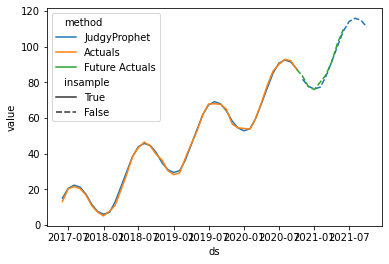

In [1]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns
from judgyprophet.tutorials.resources import get_additive_seasonality_linear_trend

example_data = get_additive_seasonality_linear_trend()


# Cutoff the data to October 2020
cutoff = "2020-10-01"
data_cutoff = example_data.loc[:cutoff]

jp = JudgyProphet()
# We are passing in a simple time series without trend or level events. The seasonality is set to 12
#     and the seasonality component is simply additive.
jp.fit(
    data=data_cutoff,
    level_events=[],
    trend_events=[],
    seasonal_period=12,
    seasonal_type="add",
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=int(12))

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

### Multiplicative Seasonality
In case of multiplicative seasonality, the seasonal variations are changing proportional to the level of the series. If multiplicative seasonality is selected, `judgyprophet` will rescale the time series by shifting all values positive with standard variance. An example is shown here:

INFO:judgyprophet.judgyprophet:Rescaling by shifting all values positive with 1-sd.


Initial log joint probability = -775.468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -105.965     0.0490619       1203.53     0.04941           1       32   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -12.2029     0.0634662       440.207      0.1485      0.1485       64   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59     -0.683534     0.0372809       68.3501           1           1       84   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79     -0.454028    0.00336031       7.70556      0.8053      0.8053      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99     -0.442297   0.000894112       6.38619    0.006837           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha  

<AxesSubplot:xlabel='ds', ylabel='value'>

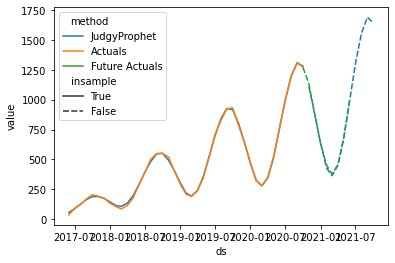

In [2]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns
from judgyprophet.tutorials.resources import get_multiplicative_seasonality_linear_trend

example_data = get_multiplicative_seasonality_linear_trend()


# Cutoff the data to October 2020
cutoff = "2020-10-01"
data_cutoff = example_data.loc[:cutoff]

jp = JudgyProphet()
# The multiplicative example time series has a constant trend component, but the seasonality
#     is multiplicative and has a large amplitude. Again the period is set to 12.
jp.fit(
    data=data_cutoff,
    level_events=[],
    trend_events=[],
    seasonal_period=12,
    seasonal_type="mult",
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=int(12))

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

### Combining Seasonality with Events
Both seasonality can be combined with trend events, damping, level events, and unspecified changepoints. We will now walk through an example time series which contains a damped trend event and shows additive seasonality. Let's look at the data:

<AxesSubplot:>

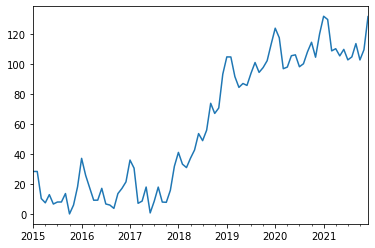

In [3]:
from judgyprophet.tutorials.resources import get_additive_seasonal_damped_trend_event

example_data = get_additive_seasonal_damped_trend_event()
example_data.plot.line()

We can see from the plot that there is an uptick in trend around January 2018. The uptick in trend is quite steep until the end of 2019 where we observe stronger damping. We also see that the time series has a seasonal pattern, with a `seasonal_period` of 12 and a peak in December each year.

#### Forecasting with JudgyProphet before the event occurs
The estimate of the trend event is a trend increase of 6 with a damping parameter of 0.9.

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.


Initial log joint probability = -5618.69
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -19.5311      0.107624       53.5313           1           1       25   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -14.4873    0.00450173       32.1225           1           1       54   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -11.3416     0.0164259       63.5553      0.1261           1       83   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       -10.031    0.00192964       42.0027      0.4045      0.4045      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99      -9.91568    0.00123052       20.6714      0.3407           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha  

<AxesSubplot:xlabel='ds', ylabel='value'>

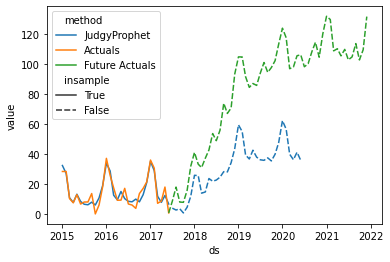

In [4]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

trend_events = [
    {'name': "New saturating market entry", 'index': '2018-01-01', 'm0': 6, 'gamma': .9}
]

# Cutoff the data to June 2017
cutoff = "2017-06-01"
data_cutoff = example_data.loc[:cutoff]

jp = JudgyProphet()
# We have one trend event and no level events. The seasonality is additive again.
jp.fit(
    data=data_cutoff,
    sigma_trend=0.1,
    level_events=[],
    unspecified_changepoints=10,
    sigma_unspecified_changepoints=.2,
    trend_events=trend_events,
    seasonal_period=12,
    seasonal_type="add",
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=int(36))

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

#### Forecasting with JudgyProphet after the event occurs
We can see that the model picks up correctly the seasonal pattern and incorporates the trend event. After a few more data points are observed, the model learned that the initial trend event estimates were poorly and corrects its forecast accordingly. Let's look at the forecast repeated in June 2018: 

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New saturating market entry to model. Event index: 2018-01-01, training data start index: 2015-01-01 00:00:00, training data end index: 2018-06-01 00:00:00. Initial gradient: 6. Damping: 0.9.


Initial log joint probability = -4219.81
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -45.4011     0.0443425       326.047           1           1       26   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -15.3423    0.00201394       41.5814           1           1       53   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -11.4289     0.0222713       70.3068           1           1       82   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79      -9.74468     0.0019911       38.3992      0.8659      0.8659      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99      -9.55453    0.00466659       25.2859       0.949       0.949      137   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/kpxh622/github/judgyprophet/judgyprophet/utils.py:31: UserWarning: Unspecified changepoint with index 2018-01-01 00:00:00 also specified as a level or trend event. Removing this changepoint.
  warnings.warn(msg)


<AxesSubplot:xlabel='ds', ylabel='value'>

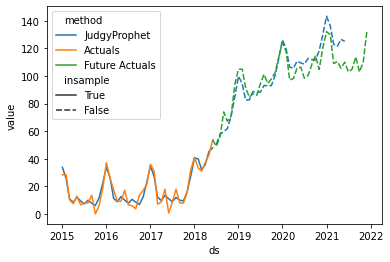

In [5]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

trend_events = [
    {'name': "New saturating market entry", 'index': '2018-01-01', 'm0': 6, 'gamma': .9}
]

# Cutoff the data to June 2017
cutoff = "2018-06-01"
data_cutoff = example_data.loc[:cutoff]

jp = JudgyProphet()
# We have one trend event and no level events. The seasonality is additive again.
jp.fit(
    data=data_cutoff,
    sigma_trend=0.1,
    level_events=[],
    unspecified_changepoints=10,
    sigma_unspecified_changepoints=.2,
    trend_events=trend_events,
    seasonal_period=12,
    seasonal_type="add",
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=int(36))

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])